# Cryptocurrency Price Prediction

Let's atttempt to predict cryptocurrency returns using machine learning techniques! 😄

**In this notebook we will:**
- Create a class to extract cryptocurrency price data
- Download cryptocurrency price data and store in a SQL database
- Download twitter data and store in a SQL database
- Engineer features for model building
- Develop machine learning models using:
    - Gradient boosting (Light GBM)
    - Recurrent neural nets using GRUs
    - NLP techniques (TF-IDF and SVMs)
    
I've gotten a bit carried away on the emojis in this notebook as I've just discovered that these can be copied into Jupyter Notebooks 😺

Get yours here 👉: https://emojikeyboard.org/copy/Main_Page

In [1]:
import cryptocompare
import datetime as dt
from datetime import timedelta
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import time
import twint 
import nest_asyncio

from sklearn.model_selection import train_test_split
from sklearn.svm import LinearSVC, SVC
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from lightgbm import LGBMClassifier
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

from sklearn.metrics import confusion_matrix, f1_score, precision_score, recall_score, accuracy_score, roc_auc_score

from keras.models import Sequential
from keras.layers import Activation, Dense, GRU
from keras.layers import Dropout
from keras import optimizers as ko
from coinbase.wallet.client import Client

pd.set_option('max_colwidth', 400)

%run "C:\Users\geoff\PycharmProjects\ml-utils\nlp_utils.py"
%run "C:\Users\geoff\PycharmProjects\ml-utils\monte_carlo_cv.py"
%run "C:\Users\geoff\PycharmProjects\db-utils\database_controller.py"
%run "C:\Users\geoff\PycharmProjects\ml-utils\ml_utils.py"

In [2]:
class CryptoDataExtractor:
    """
    A class to extract crypto price data from CryptoCompare
    """
    
    def __init__(self, coins=None, currency='GBP', exchange='Coinbase'):
        self.coins = coins
        self.currency = currency
        self.exchange = exchange
        
    def get_pairs(self, exchange='Coinbase'):
        """Get pairs available from a given exchange"""
        
        pairs_list = []
        pairs = cryptocompare.get_pairs(exchange=exchange)
        for pair in pairs:
            if pair['tsym'] == self.currency:
                pairs_list.append(pair['fsym'])

        self.coins = pairs_list
        
    def get_price_data(self, limit=2000, freq='daily', verbose=True):
        """Get price data"""
        
        if verbose:
            print('Downloading price data...')
            
        df = pd.DataFrame()

        for coin in self.coins:
            if verbose:
                print(coin)
            first = True
            
            if freq == 'daily':
                recs = cryptocompare.get_historical_price_day(coin, self.currency, limit=limit, 
                                                              exchange=self.exchange, toTs=dt.datetime.now())
            elif freq == 'hourly':
                recs = cryptocompare.get_historical_price_hour(coin, self.currency, limit=limit, 
                                                               exchange=self.exchange, toTs=dt.datetime.now())
            else:
                raise ValueError(f'{freq} is not a valid frequency. Use either "daily" or "hourly"')
                
            price_list = []
            volume_list = []
            date_list = []
            
            for rec in recs:    
                if first:
                    date_list.append(time.strftime('%Y-%m-%d %H:%M:%S', time.localtime(rec['time'])))
                    
                price_list.append(rec['close'])
                volume_list.append(rec['volumeto'] + 1e-6)
                
            df[coin] = price_list
            df[coin + '_vol'] = volume_list
            first = False
            
        df.index = date_list
        
        return df
    

In [3]:
# Helper functions
def feature_engineering(df, features=None, rolling_averages=[3, 6, 12], target_var='BTC', 
                        shift=1, thresh=0.00, gt=True, drop=['Datetime']):
    """Do feature engineering"""

    df_copy = df.copy()
    _max = max(rolling_averages)
    if features is None:
        features = df_copy.columns.to_list()
        features.remove('Datetime')

    # Create percent change features
    for feature in features: 
        df_copy[feature + '_1'] = df_copy[feature].pct_change(periods=1)
        df_copy[feature + '_3'] = df_copy[feature].pct_change(periods=3)
        df_copy[feature + '_6'] = df_copy[feature].pct_change(periods=6)
        df_copy[feature + '_12'] = df_copy[feature].pct_change(periods=12)

        # Drop original feature
        df_copy.drop(feature, axis=1, inplace=True)

    # Create datetime variables
    #df_copy['Datetime'] = df_copy['Datetime'].apply(lambda x: dt.datetime.strptime(x,'%Y-%m-%d %H:%M:%S'))
    df_copy['hour'] = df_copy['Datetime'].apply(lambda x: dt.datetime.strptime(x,'%Y-%m-%d %H:%M:%S').hour)
    df_copy['weekday'] = df_copy['Datetime'].apply(lambda x: dt.datetime.strptime(x,'%Y-%m-%d %H:%M:%S').weekday())

    if len(rolling_averages) > 0:
        for avg in rolling_averages:
            for feature in features:
                df_copy[feature + '_avg' + str(avg)] = df_copy[feature + '_1'].rolling(avg).mean()

    df_copy['y'] = _create_target(df_copy, target_var, shift, thresh, gt)
    df_copy.drop(['_tmp_'], axis=1, inplace=True)
    if drop is not None:
        df_copy.drop(drop, axis=1, inplace=True)

    return df_copy.iloc[_max:, :]

def plot_prices(df, coins):
    """Plot price data"""

    fig, ax = plt.subplots(figsize=(8, 6))
    ax.set_title('Crypto Prices (indexed on first record)')
    for coin in coins:
        ax.plot(df[coin]/df[coin][0], label=coin)
    plt.legend(loc='upper left', bbox_to_anchor=(0.0, -0.1), frameon=False)
    plt.show()

def plot_distribution(df, var):
    """Plot distribution of a variable"""

    fig, ax = plt.subplots(figsize=(8, 6))
    ax.set_title(f'{var} distribution')
    ax = sns.kdeplot(df[var], label=var, fill=True, alpha=0.25)
    plt.legend(loc='upper left', bbox_to_anchor=(0.0, -0.1), frameon=False)
    plt.show()        

def _create_target(df, target_var, shift, thresh=0.00, gt=True):
    """Create target variable"""

    df['_tmp_'] = df[target_var + '_' + str(shift)].shift(-shift)
    if gt:
        return np.where(df['_tmp_'] > thresh, 1, 0)
    else:
        return np.where(df['_tmp_'] < thresh, 1, 0)


### 1. Get crypto price data 📈
First lets get crypto price data using our CryptoDataExtractor class

In [4]:
# List of coins to get data for
coins = ['BTC', 'ETC', 'ETH', 'LTC', 'BCH', 'ALGO', 'XTZ', 'LINK', 'OMG', 'BAND', 'UMA', 'NMR', 'CELO', 'NU',
            'FIL', 'SNX', 'BNT', 'AAVE', 'GRT']

# Create new instance of CryptoDataExtractor and find GBP pairs
cc = CryptoDataExtractor(coins=coins, currency='GBP')

# Get the price data
df = cc.get_price_data(freq='hourly')

BTC
ETC
ETH
LTC
BCH
ALGO
XTZ
LINK
OMG
BAND
UMA
NMR
CELO
NU
FIL
SNX
BNT
AAVE
GRT


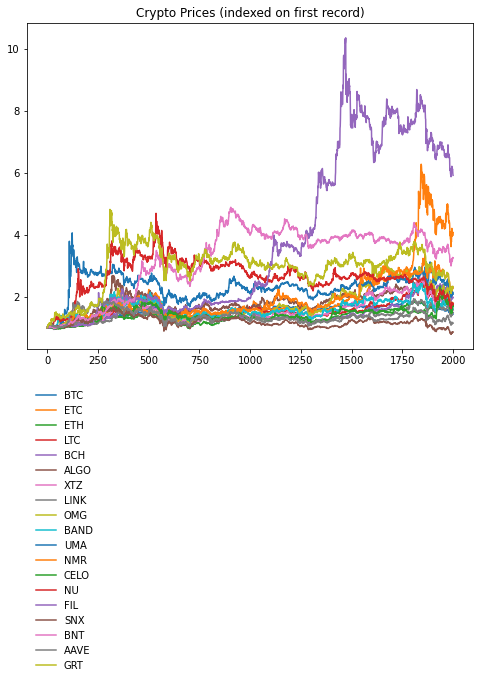

In [5]:
# Plot the prices
plot_prices(df.reset_index(drop=True), coins)

### 2. Save raw data to database 💾
Save the downloaded data into the crypto_prices database

In [6]:
DATABASE_NAME = 'crypto_prices.db'

# Create database controller instance and create prices table if it doesn't already exist
dbc = DatabaseController(DATABASE_NAME)
create_string = f'CREATE TABLE IF NOT EXISTS Prices (' \
              + 'Datetime TEXT PRIMARY KEY, ' + ' REAL, '.join(df.columns.tolist()) \
              + ')'
dbc.create_table(create_string)

In [7]:
# Delete the last row in the table as this may contain incomplete data if downloaded within
# the hour
dbc._access_database(f'DELETE FROM Prices WHERE Datetime in(SELECT MAX(Datetime) FROM Prices)')

# Get max date from database
max_date = dbc._access_database_with_result(f'SELECT Datetime FROM Prices ORDER BY Datetime DESC LIMIT 1', 
                                            pandas_df=False)[0][0]
print(max_date)

# Keep only new records greater than the max date
data_to_insert = df.copy()
data_to_insert.reset_index(inplace=True)
data_to_insert = data_to_insert[data_to_insert['index'] > max_date]
data_to_insert = data_to_insert.values.tolist()

2021-04-23 16:00:00


In [9]:
# Add new records to database
print(f'{len(data_to_insert)} records to add')
dbc.add_data('Prices', data_to_insert)

2 records to add


### 3. Get twitter data 🔊
Download data from twitter using the twint library.

Let's just get all the tweets that mention BTC for now, on the presumption that tweets about BTC will act as a barometer for interest in cryptocurrency in general.

We will transform this data by counting the number of times BTC is mentioned each hour. We will store this data in a SQL database. Later on we will explore more involved NLP techniques.

In [10]:
nest_asyncio.apply()

def get_tweets(search, since, until, output=None, pandas_df=False, limit=None, username=None, verified=True, 
               hide_output=True, lang='en'):
    """
    Wrapper function to get tweets using the twint library
    """
    
    c = twint.Config()
    c.Search = search
    
    c.Since = since
    c.Until = until
    
    if limit is not None:
        c.Limit = limit
    
    if username is not None:
        c.Username = username
        
    c.Verified = verified
    c.Hide_output = hide_output
    c.Lang = lang
    c.Lower_case = True
    c.Count = True
    
    if output is not None:
        c.Store_csv = True
        c.Custom_csv = ['id', 'user_id', 'username', 'tweet']
        c.Output = output

    c.Pandas = pandas_df   
    
    # run search
    twint.run.Search(c)
    
    df = twint.storage.panda.Tweets_df
    
    if pandas_df:
        return twint.storage.panda.Tweets_df
    
    
def hourly_tweet_counts(df):
    """
    Count the number of times that a term has been tweeted about within an hour
    """
    
    # We only need the datetime and tweet fields
    df_tmp = df[['date', 'tweet']].copy()
    # Datetime in string format rounded to hour
    df_tmp['datetime_rnd'] = df_tmp['date'].copy().str[:13] + ':00:00'
    # Convert to datetime format to subtract 1 hour
    df_tmp['datetime_dt'] =  pd.to_datetime(df_tmp['datetime_rnd'], format='%Y-%m-%d %H:%M:%S') - timedelta(hours=1)
    # Convert back to string format
    df_tmp['datetime'] = df_tmp['datetime_dt'].apply(lambda x: x.strftime('%Y-%m-%d %H:%M:%S'))
    df_tmp['tweet_count'] = 1
    
    # Aggregate number of tweets by hour
    tweets_agg = df_tmp.groupby('datetime').agg({'tweet_count':'sum'}).reset_index()
   
    return tweets_agg


In [11]:
# Get tweet data for selected coins and aggregate into hourly counts
coin = 'BTC' 
since = '2021-01-25'
until = '2021-12-31'

tweets_df = get_tweets(coin, since, until, pandas_df=True, hide_output=True)
tweets_df_count = hourly_tweet_counts(tweets_df)

[!] No more data! Scraping will stop now.
found 0 deleted tweets in this search.
[+] Finished: Successfully collected 17413 Tweets.


In [12]:
# Store data in a SQL database
TABLE_NAME = 'BTC_hourly_tweet_counts'

dbc = DatabaseController(DATABASE_NAME)
create_string = f'CREATE TABLE IF NOT EXISTS BTC_hourly_tweet_counts (' \
              + 'Datetime TEXT PRIMARY KEY, BTC_hourly_tweets INT' \
              + ')'
dbc.create_table(create_string)

# Delete the last row in the table as this may contain incomplete data if downloaded within
# the hour
dbc._access_database(f'DELETE FROM {TABLE_NAME} WHERE Datetime in(SELECT MAX(Datetime) FROM BTC_hourly_tweet_counts)')

# Get max date from database
max_date = dbc._access_database_with_result(f'SELECT Datetime FROM BTC_hourly_tweet_counts ORDER BY Datetime DESC LIMIT 1', 
                                            pandas_df=False)[0][0]
print(max_date)

# Keep only new records greater than the max date
data_to_insert = tweets_df_count.copy()
data_to_insert = data_to_insert[data_to_insert['datetime'] > max_date]
data_to_insert = data_to_insert.values.tolist()

# Add new records to database
print(f'{len(data_to_insert)} records to add')
dbc.add_data(TABLE_NAME, data_to_insert)

2021-04-23 15:00:00
2 records to add


### 4. Feature engineering 🔬
In this section we will merge the price and tweets data and generate some basic features and create our target variable.

We will convert the data to returns using different lookback periods and also compute average returns over different lookback periods.

Our target varirable will be whether or not ETH exceeds a 2% return in the next 6 hours.

In [13]:
# Get the data
prices_df = dbc.get_table('Prices')
tweets_df = dbc.get_table('BTC_hourly_tweet_counts')

# Merge data and clean 
df = pd.merge(prices_df, tweets_df, how="left", left_on=prices_df['Datetime'], right_on=tweets_df['Datetime'])
df.drop(['key_0', 'Datetime_y'], axis=1, inplace=True)
df.rename(columns={'Datetime_x': 'Datetime'}, inplace=True)
df.fillna(0, inplace=True)
df.head()

,Datetime,BTC,BTC_vol,ETC,ETC_vol,ETH,ETH_vol,LTC,LTC_vol,BCH,...,FIL_vol,SNX,SNX_vol,BNT,BNT_vol,AAVE,AAVE_vol,GRT,GRT_vol,BTC_hourly_tweets
0,2021-01-25 12:00:00,24995.46,3.347062e+06,5.747,7466.540001,1042.19,1.312365e+06,106.37,139571.760001,334.72,...,7624.360001,12.55,81919.430001,1.513,31924.740001,192.42,187001.130001,0.4155,90773.600001,7.0
1,2021-01-25 13:00:00,25288.02,2.677206e+06,5.712,14309.710001,1037.84,1.148182e+06,106.36,200572.320001,337.33,...,8056.950001,12.21,49753.440001,1.499,11146.600001,189.91,77602.040001,0.4240,103460.760001,12.0
2,2021-01-25 14:00:00,25270.62,1.972348e+06,5.694,13477.130001,1030.24,8.825863e+05,105.75,94438.370001,333.59,...,9231.720001,11.99,55458.170001,1.483,4608.950001,184.18,42289.280001,0.4094,31658.580001,8.0
3,2021-01-25 15:00:00,25223.66,1.361675e+06,5.697,17812.100001,1049.68,9.996227e+05,106.49,48559.100001,336.07,...,3350.630001,12.18,31481.240001,1.496,9137.330001,187.54,61465.580001,0.4118,23319.030001,6.0
4,2021-01-25 16:00:00,24799.75,2.483954e+06,5.549,46813.760001,1028.45,1.524829e+06,104.30,81960.340001,329.14,...,2251.180001,11.69,122859.000001,1.448,5559.500001,183.48,95547.060001,0.4072,52591.290001,7.0


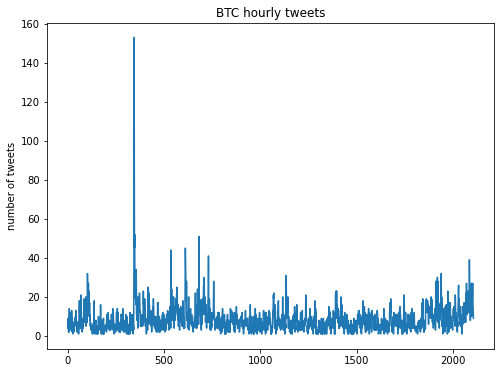

In [14]:
# Out of interest let's plot the number of BTC tweets over time
plt.figure(figsize=(8, 6))
plt.title(f'BTC hourly tweets')
plt.plot(tweets_df['BTC_hourly_tweets'])
plt.ylabel('number of tweets')
plt.show()

In [15]:
# Do feature engineering
TARGET_VAR = 'ETH'
SHIFT = 6
THRESH = 0.02
FEATURES = prices_df.columns.to_list()
FEATURES.remove('Datetime')

df = feature_engineering(df, features=FEATURES, target_var=TARGET_VAR, shift=SHIFT, thresh=THRESH, gt=True)
df.head()

,BTC_hourly_tweets,BTC_1,BTC_3,BTC_6,BTC_12,BTC_vol_1,BTC_vol_3,BTC_vol_6,BTC_vol_12,ETC_1,...,FIL_vol_avg12,SNX_avg12,SNX_vol_avg12,BNT_avg12,BNT_vol_avg12,AAVE_avg12,AAVE_vol_avg12,GRT_avg12,GRT_vol_avg12,y
12,0.0,0.007320,-0.005820,-0.035762,-0.047800,0.016833,-0.571342,-0.021936,-0.539512,0.010358,...,0.019440,-0.003715,0.415512,-0.003379,0.358499,0.002638,0.090581,-0.002507,0.146437,0
13,7.0,0.007247,0.008301,-0.020303,-0.051995,-0.603184,-0.833703,-0.197074,-0.771551,0.004856,...,0.091623,-0.002015,0.399184,-0.003412,0.330692,0.002367,0.110264,-0.005392,0.070044,0
14,3.0,-0.013397,0.001027,-0.033824,-0.064051,-0.296724,-0.716231,-0.644061,-0.781921,-0.013782,...,0.199302,-0.002338,0.320829,-0.003450,0.948603,0.002653,0.081254,-0.004392,0.081503,0
15,1.0,-0.022662,-0.028767,-0.034419,-0.083559,1.695498,-0.247764,-0.677548,-0.148542,-0.023049,...,0.189666,-0.006168,0.607084,-0.006057,0.940950,-0.001585,0.184553,-0.007073,0.868997,0
16,0.0,0.016891,-0.019468,-0.011328,-0.052149,-0.629749,-0.298123,-0.883280,-0.827182,0.007617,...,0.451069,-0.000597,0.305740,-0.003024,0.942802,0.003911,0.128133,-0.004354,0.696363,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2113,15.0,-0.001756,-0.006066,0.032722,-0.036252,-0.161013,-0.604740,-0.699032,-0.433701,-0.007766,...,0.006209,-0.003277,0.639438,-0.002312,0.120310,-0.005972,0.377924,-0.003549,0.195255,0
2114,15.0,0.015452,-0.003347,0.025210,-0.000800,-0.035942,-0.606505,-0.698146,-0.649945,0.034070,...,0.066137,0.003039,0.398087,0.002978,0.047628,-0.000295,0.259146,0.003918,0.037610,0
2115,12.0,0.002240,0.015940,0.039037,-0.005166,-0.151372,-0.313603,-0.548021,-0.040478,-0.005788,...,0.084102,0.000736,0.430520,0.001985,0.072691,-0.000655,0.561942,0.002157,0.022586,0
2116,9.0,-0.000142,0.017582,0.011409,0.019256,0.019135,-0.166219,-0.670440,-0.029074,0.003135,...,0.150716,0.005328,0.443181,0.003929,-0.008534,0.003045,0.540856,0.005463,0.225422,0


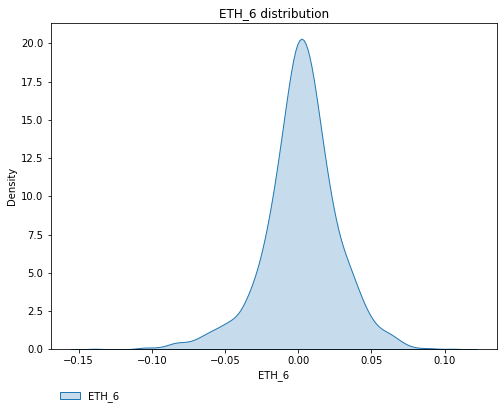

In [16]:
# Plot distribution of target variable
plot_distribution(df, TARGET_VAR + "_" + str(SHIFT))

### 5. Build preliminary models 🔨
Now we will split the data into train and test sets and then use monte carlo cross-validation to compare several algorithms.

We will take whatever algorithm performs best using over cross-validation and use it to build a model on the entire training set and then evaluate test set performance.

In [17]:
# Check target counts
df['y'].value_counts()

0    1687
1     419
Name: y, dtype: int64

In [18]:
# Create train and test datasets
y = df['y']
x = df.drop('y', axis=1)

# Use train_test_split to create training and testing datasets
test_size = 0.4
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=test_size, random_state=42, shuffle=False)

print(f'% of data to use for training {(1-test_size)*100}%')
print(f'training set observations: {len(x_train)}')
print(f'training set events: {sum(y_train)} \n')
print(f'% of data to use for testing {test_size*100}%')
print(f'test set observations: {len(x_test)}')
print(f'test set events: {sum(y_test)}')

% of data to use for training 60.0%
training set observations: 1263
training set events: 263 

% of data to use for testing 40.0%
test set observations: 843
test set events: 156


In [19]:
# Monte Carlo CV
models = [DecisionTreeClassifier(max_depth=3), LGBMClassifier(), RandomForestClassifier()]
mccv = MonteCarloCV(models, number_of_runs=100)
mccv.train(x_train.values, y_train.values, verbose=True, verbose_n=25)

Model 0
Iteration 0 - cumulative average score: 0.5344272575250836
Iteration 25 - cumulative average score: 0.5514991534597032
Iteration 50 - cumulative average score: 0.5482544506849324
Iteration 75 - cumulative average score: 0.5508129411738619
Model 0 average accuracy: 0.5504414351130086 

Model 1
Iteration 0 - cumulative average score: 0.8236204013377927
Iteration 25 - cumulative average score: 0.7911232148586271
Iteration 50 - cumulative average score: 0.7911646577456009
Iteration 75 - cumulative average score: 0.7903779311322253
Model 1 average accuracy: 0.7912606060166999 

Model 2
Iteration 0 - cumulative average score: 0.7627090301003344
Iteration 25 - cumulative average score: 0.7544316465389398
Iteration 50 - cumulative average score: 0.7515581889387842
Iteration 75 - cumulative average score: 0.749332909666727
Model 2 average accuracy: 0.750897004532614 



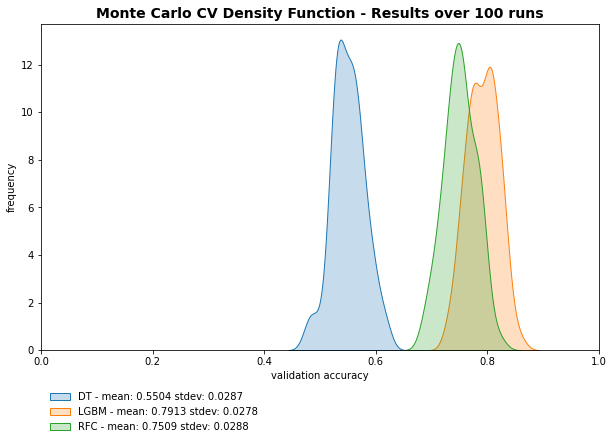

In [20]:
# Plot the cv results
model_labels = ['DT', 'LGBM', 'RFC']
mccv.plot_scores(labels=model_labels, xlim=(0.0, 1.0))

In [21]:
# Light GBM performs the best - build a Light GBM model on the entire training set and apply to test set
clf = LGBMClassifier()
clf.fit(x_train, y_train)

y_train_pred = clf.predict(x_train)
y_test_pred = clf.predict(x_test)

print_metrics(y_train, y_train_pred, y_test, y_test_pred)

training set performance:
training precision score: 1.0
training recall score: 1.0
training f1 score: 1.0

test set performance:
testing precision score: 0.4444
testing recall score: 0.0256
testing f1 score: 0.0485


### 6. Build models for each cryptocurrency 📊

Let's extend the model from the previous section and try building light gbm models for all cryptocurrencies.

We will keep the target definition parameters the same - at least a 2% increase within the following 6 hours.

Additionally we will trial different probability thresholds to examine the impact this has on precision and recall.

In [22]:
def train_models(df, cryptos, cc, shift=3, thresh=0.02, prob_thresholds=[0.5, 0.6, 0.7, 0.8], 
                 clf=LGBMClassifier()):
    """
    Train separate models for each cryptocurrency
    """
    
    results_df = pd.DataFrame()
    
    # Get the data
    prices_df = dbc.get_table('Prices')
    tweets_df = dbc.get_table('BTC_hourly_tweet_counts')

    # Merge data and clean 
    df_raw = pd.merge(prices_df, tweets_df, how='left', left_on=prices_df['Datetime'], right_on=tweets_df['Datetime'])
    df_raw.drop(['key_0', 'Datetime_y'], axis=1, inplace=True)
    df_raw.rename(columns={'Datetime_x': 'Datetime'}, inplace=True)
    df_raw.fillna(0, inplace=True)
    FEATURES = prices_df.columns.to_list()
    FEATURES.remove('Datetime')

    for crypto in cryptos:
        # Feature engineering
        df = feature_engineering(df_raw, features=FEATURES, target_var=crypto, shift=shift, thresh=thresh, gt=True)

        # Create train and test datasets
        y = df['y']
        x = df.drop('y', axis=1)

        # Use train_test_split to create training and testing datasets
        test_size = 0.4
        x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=test_size, random_state=42, shuffle=False)

        # Train classifier
        clf = LGBMClassifier()
        clf.fit(x_train, y_train)
        
        # Iterate through probability thresholds
        for prob_threshold in prob_thresholds:
            y_test_pred = adjusted_classes(clf.predict_proba(x_test)[:, 1], prob_threshold)
            y_test_prob = clf.predict_proba(x_test)[:, 1]

            # Get performance metrics
            auc = round(roc_auc_score(y_test, y_test_prob), 4)
            prec = round(precision_score(y_test, y_test_pred), 4)
            rec = round(recall_score(y_test, y_test_pred), 4)
            f1 = round(f1_score(y_test, y_test_pred), 4)
    
            results = [crypto, y_test.sum(), prob_threshold, auc, prec, rec, f1]

            results_df = results_df.append([results])

    results_df.columns = ['crypto', 'events', 'prob_threshold', 'auc', 'precision', 'recall', 'f1']

    return results_df
    

In [23]:
# Train all the models and sort by precision
results_df = train_models(df, cc.coins, cc, shift=6, thresh=0.02)
results_df.sort_values('precision', ascending=False, inplace=True)
results_df[:30]

,crypto,events,prob_threshold,auc,precision,recall,f1
0,ETH,156,0.7,0.5932,0.6667,0.0128,0.0252
0,ETH,156,0.8,0.5932,0.6667,0.0128,0.0252
0,BTC,64,0.8,0.6162,0.6667,0.0312,0.0597
0,CELO,181,0.7,0.4964,0.6000,0.0331,0.0628
0,CELO,181,0.8,0.4964,0.5714,0.0221,0.0426
0,BTC,64,0.7,0.6162,0.5000,0.0469,0.0857
0,BCH,201,0.7,0.5450,0.5000,0.0398,0.0737
0,CELO,181,0.6,0.4964,0.5000,0.0497,0.0905
0,ETH,156,0.6,0.5932,0.5000,0.0128,0.0250
0,ETC,251,0.5,0.6115,0.4878,0.0797,0.1370


### 7. Recurrent neural networks 🧠

Okay, our light gbm models haven't exactly done a great job so far 😅. In the few cases where precision is high, recall is far too low to be useful or statistically robust.

Can we do better using a more advanced model such as recurrent neural networks?

In this section we will transform the data into sequences and use a Gated Recurrent Unit (GRU) to predict returns.

We will generate sequences of 96 hours (4 days) to predict returns, this period has been chosen arbitrarily.

The target definition parameters remain the same: at least a 2% increase in the following 6 hours.

In [24]:
def create_rnn_data(x_train, y_train, x_test, y_test, seq_length, examples=None, random_seed=42):
    """
    Creates training sequences for an rnn model
    """
    
    # Set numpy random seed
    np.random.seed(random_seed)
    
    x_train_values = x_train.values
    y_train_values = y_train.values
    x_test_values = x_test.values
    y_test_values = y_test.values
    
    # Create training set sequences
    if examples is None:
        ts = x_train.shape[0] - seq_length
        x_train_rnn = np.zeros((ts, x_train.shape[1], seq_length))
        y_train_rnn = np.zeros((ts, 1))

        for i in range(x_train.shape[0]-seq_length):
            for j in range(x_train.shape[1]):
                x_train_rnn[i, j, :] = x_train_values[:, j][i:i+seq_length]

            y_train_rnn[i, :] = y_train_values[i+seq_length-1]
    else:
        x_train_rnn = np.zeros((examples, x_train.shape[1], seq_length))
        y_train_rnn = np.zeros((examples, 1))

        for i in range(examples):
            r = np.random.randint(seq_length, x_train.shape[0])
            for j in range(x_train.shape[1]):
                x_train_rnn[i, j, :] = x_train_values[:, j][r-seq_length:r]

            y_train_rnn[i, :] = y_train_values[r]

    print(f'x_train_rnn shape: {x_train_rnn.shape}')
    print(f'y_train_rnn shape: {y_train_rnn.shape} \n')

    # Create test set sequences
    ts = x_test.shape[0] - seq_length
    x_test_rnn = np.zeros((ts, x_test.shape[1], seq_length))
    y_test_rnn = np.zeros((ts, 1))

    for i in range(x_test.shape[0]-seq_length):
        for j in range(x_test.shape[1]):
            x_test_rnn[i, j, :] = x_test_values[:, j][i:i+seq_length]

        y_test_rnn[i, :] = y_test_values[i+seq_length-1]

    print(f'x_test_rnn shape: {x_test_rnn.shape}')
    print(f'y_test_rnn shape: {y_test_rnn.shape}')
        
    return x_train_rnn, y_train_rnn, x_test_rnn, y_test_rnn
    

In [25]:
# Create sequence data for RNNs
x_train_rnn, y_train_rnn, x_test_rnn, y_test_rnn = create_rnn_data(x_train, y_train, x_test, y_test, 96)

x_train_rnn shape: (1167, 269, 96)
y_train_rnn shape: (1167, 1) 

x_test_rnn shape: (747, 269, 96)
y_test_rnn shape: (747, 1)


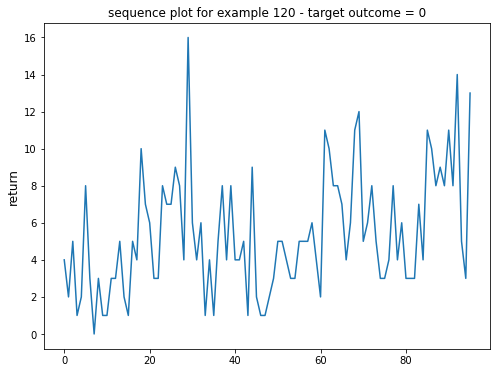

In [26]:
# Plot an example of a sequence and the target outcome
idx = 120

plt.figure(figsize=(8, 6))
plt.title(f'sequence plot for example {idx} - target outcome = {int(y_train_rnn[idx][0])}')
plt.plot(x_train_rnn[idx, 0])
plt.ylabel('return', fontsize=12)
plt.show()

**Time to train the GRU model** - the architecture has been chosen arbitrarily, we could spend a lot of time trialling different configurations

In [27]:
# Train GRU model
def gru_model():
    model = Sequential()
    model.add(GRU(64, input_shape=(x_train_rnn.shape[1], x_train_rnn.shape[2]), return_sequences=True))
    model.add(Dropout(0.5))
    model.add(GRU(16, return_sequences=False))
    model.add(Dropout(0.5))
    model.add(Dense(1))
    model.add(Activation('sigmoid'))
    
    optimizer = ko.Adam(lr=0.01, beta_1=0.9, beta_2=0.999, decay=1e-6)
    model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['mae'])
    
    return model

model = gru_model()
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru (GRU)                    (None, 269, 64)           31104     
_________________________________________________________________
dropout (Dropout)            (None, 269, 64)           0         
_________________________________________________________________
gru_1 (GRU)                  (None, 16)                3936      
_________________________________________________________________
dropout_1 (Dropout)          (None, 16)                0         
_________________________________________________________________
dense (Dense)                (None, 1)                 17        
_________________________________________________________________
activation (Activation)      (None, 1)                 0         
Total params: 35,057
Trainable params: 35,057
Non-trainable params: 0
____________________________________________________

In [28]:
# Shuffle the data before training
np.random.seed(42)
np.random.shuffle(x_train_rnn)
np.random.seed(42)
np.random.shuffle(y_train_rnn)

# Fit the model
model.fit(x_train_rnn, y_train_rnn, batch_size=128, epochs=20, verbose=2)

Epoch 1/20
10/10 - 3s - loss: 0.5627 - mae: 0.3381
Epoch 2/20
10/10 - 3s - loss: 0.5423 - mae: 0.3299
Epoch 3/20
10/10 - 3s - loss: 0.5434 - mae: 0.3281
Epoch 4/20
10/10 - 3s - loss: 0.5300 - mae: 0.3297
Epoch 5/20
10/10 - 3s - loss: 0.5141 - mae: 0.3191
Epoch 6/20
10/10 - 3s - loss: 0.5005 - mae: 0.3266
Epoch 7/20
10/10 - 3s - loss: 0.5019 - mae: 0.3203
Epoch 8/20
10/10 - 3s - loss: 0.4833 - mae: 0.3124
Epoch 9/20
10/10 - 3s - loss: 0.4708 - mae: 0.3068
Epoch 10/20
10/10 - 3s - loss: 0.4656 - mae: 0.2911
Epoch 11/20
10/10 - 3s - loss: 0.4212 - mae: 0.2652
Epoch 12/20
10/10 - 3s - loss: 0.4378 - mae: 0.2582
Epoch 13/20
10/10 - 4s - loss: 0.4537 - mae: 0.2884
Epoch 14/20
10/10 - 4s - loss: 0.4126 - mae: 0.2725
Epoch 15/20
10/10 - 3s - loss: 0.4205 - mae: 0.2510
Epoch 16/20
10/10 - 4s - loss: 0.3577 - mae: 0.2286
Epoch 17/20
10/10 - 3s - loss: 0.3560 - mae: 0.2210
Epoch 18/20
10/10 - 4s - loss: 0.3545 - mae: 0.2082
Epoch 19/20
10/10 - 4s - loss: 0.3230 - mae: 0.1951
Epoch 20/20
10/10 - 4

In [29]:
# Compute predicted probabilities
y_train_prob = [x[0]for x in model.predict(x_train_rnn)]
y_test_prob = [x[0] for x in model.predict(x_test_rnn)]

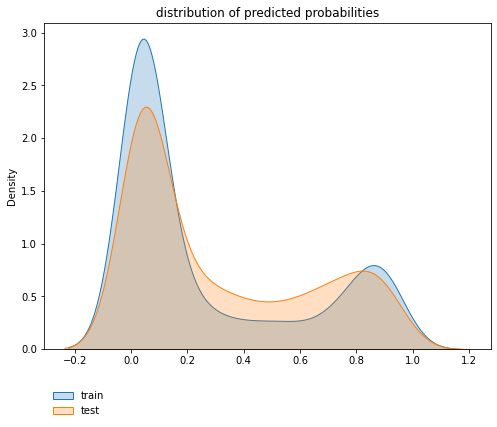

In [30]:
# Check distribution of predictions
fig, ax = plt.subplots(figsize=(8, 6))
ax.set_title(f'distribution of predicted probabilities')
ax = sns.kdeplot(y_train_prob, label='train', fill=True, alpha=0.25)
ax = sns.kdeplot(y_test_prob, label='test', fill=True, alpha=0.25)
plt.legend(loc='upper left', bbox_to_anchor=(0.0, -0.1), frameon=False)
plt.show()      

In [31]:
# Get performance metrics
y_train_pred = [int(x>=0.5) for x in y_train_prob]
y_test_pred = [int(x>=0.5) for x in y_test_prob]

print_metrics(y_train_rnn, y_train_pred, y_test_rnn, y_test_pred)

training set performance:
training precision score: 0.691
training recall score: 0.8703
training f1 score: 0.7704

test set performance:
testing precision score: 0.2335
testing recall score: 0.3442
testing f1 score: 0.2782


### 8. Using NLP to predict prices ☎️

Okay let's try one final thing - does tweet content have any impact on crypto prices?

Earlier we examined the volume of tweets, now let's consider the actual words contained in the tweets.

We will combine all tweets within a given hour and then transform the aggregrated data using a bag of words model weighted by term frequency - inverse document frequency (TF-IDF). We will then use a Support Vector Machine (SVM) to predict returns.

Our target variable is binary - does the price of ETH increase by more than 2% in the following 6 hours.

In [32]:
# Utility functions
def adjust_datetime(df):
    """
    Rounds datetime of a tweet to nearest hour and subtracts an hour
    """
    
    df_tmp = df[['date', 'tweet']].copy()
    # Datetime in string format rounded to hour
    df_tmp['datetime_rnd'] = df_tmp['date'].copy().str[:13] + ":00:00"
    # Convert to datetime format to subtract 1 hour
    df_tmp['datetime_dt'] =  pd.to_datetime(df_tmp['datetime_rnd'], format='%Y-%m-%d %H:%M:%S') - timedelta(hours=1)
    # Convert back to string format
    df_tmp['datetime'] = df_tmp['datetime_dt'].apply(lambda x: x.strftime('%Y-%m-%d %H:%M:%S'))
    
    return df_tmp

def combine_tweets_by_datetime(df, dt_feature_name='datetime'):
    """
    Combine all tweets within a given hour
    """
    
    tweet_list = []
    combined_tweet = ""
    
    df.sort_values(dt_feature_name, inplace=True, ascending=False)
    df.reset_index(drop=True, inplace=True)
    
    for row in range(df.shape[0]):

        current_dt = df[dt_feature_name][row]
        current_tweet = df['tweet'][row]
        
        if row == 0 or current_dt == prev_dt:
            combined_tweet +=  current_tweet
        else:
            tweet_list.append([current_dt, combined_tweet])
            combined_tweet = ""
            
        prev_dt = current_dt
            
    tweet_df = pd.DataFrame(tweet_list)
    tweet_df.columns = [dt_feature_name, 'tweet']
    
    return tweet_df


In [33]:
# Get tweet data for ETH
coin = 'ETH'
since = '2021-01-25'
until = '2021-12-31'

tweets_df = get_tweets(coin, since, until, pandas_df=True, hide_output=True)

[!] No more data! Scraping will stop now.
found 0 deleted tweets in this search.
[+] Finished: Successfully collected 10666 Tweets.


In [34]:
# Clean and transform the tweets
tweets_df_clean = clean_text_data(tweets_df, 'tweet')
tweets_df_clean = adjust_datetime(tweets_df_clean)
tweets_df_clean = combine_tweets_by_datetime(tweets_df_clean)

In [35]:
# Feature engineering
TARGET_VAR = 'ETH'
SHIFT = 6
THRESH = 0.02
FEATURES = ['ETH']

prices_df = dbc.get_table('Prices')
target_df = feature_engineering(prices_df, features=FEATURES, target_var=TARGET_VAR, shift=SHIFT, thresh=THRESH, gt=True,
                        drop=None)
target_df = target_df[['Datetime', 'y']]

In [36]:
# Check target counts
target_df['y'].value_counts()

0    1687
1     419
Name: y, dtype: int64

In [37]:
# Merge data and replace missing values 
df = pd.merge(target_df, tweets_df_clean, how="left", left_on='Datetime', right_on='datetime')
df.drop(['datetime', 'Datetime'], axis=1, inplace=True)
df.fillna('notweetinthistweet', inplace=True)
df.replace('', 'notweetinthistweet', inplace=True)
df.head(10)

,y,tweet
0,0,notweetinthistweet
1,0,darrenrovell reminds traded eth xrp yearwyattriot think read eth day launched didnt really tools understand dont regret gamestop actually believed thesis research bought in impatient conviction through thats worse
2,0,traded eth enj come brosrandom holding alot eth diversified bit think enj potential going good news comingsamkazemian andrecronjetech iearnfinance charlieeth bantg curvefinance hey andrecronjetech know sam support fully
3,0,notweetinthistweet
4,0,tron btc eth ltc trc usdt trc tronfoundation justinsuntron trx btt httpstconoecnuzdg political ackermann eth after meetings gov officials csos opposition want encourage anew continuation eths reform course amp national dialogue complete humanitarian access tigray amp deescalation border conflict sdn httpstcoravjfpw
5,0,hours rt following gokhshteinmedia on goal crypto good luck btc xrp eth pacjustlendpools sun trx jst btc win sun usdt usdj wbtt ethjustlend httpstconrbtrqmzz trx jst btc win sun usdt usdj wbtt eth httpstcocqmlxijsspbitkeepos supports deposit amp withdraw ethtrontrceth httpstcovkvsjspqbitpiewallet hin h tr gi amp rt ethtron trc eth httpstcovdzttvowbdphn thng u tin cho t khai thc justlendpools s...
6,0,ethtron bitkeepos eth trc tron bitkeep bitkeep httpstcojzfbmdpqnu tron trx tronfoundations gerhard schmitt promoted computeraided architecture eth zurich later member executive board shaped institutions global presence retired post prof information architecture look back httpstcogtkezsnmnxden erjahren verhalf gerhard schmitt der eth zrich zu computergesttzter architektur spter als mitglied der...
7,0,coindeskjapan eth httpstcojookdrqwdavidgokhshtein look years ahead choose ada btc eth
8,0,notweetinthistweet
9,0,notweetinthistweet


In [38]:
# Create training and test datasets
tweets_list = df.values.tolist()

x = [x[1] for x in tweets_list]
y = [x[0] for x in tweets_list]

x_train_tweet, x_test_tweet, y_train, y_test = train_test_split(x, y, test_size=0.4, random_state=42, shuffle=False)

print(f'% of data to use for training {(1-test_size)*100}%')
print(f'training set observations: {len(x_train)}')
print(f'training set positive reviews: {sum(y_train)} \n')
print(f'% of data to use for testing {test_size*100}%')
print(f'test set observations: {len(x_test)}')
print(f'test set positive reviews: {sum(y_test)}')

% of data to use for training 60.0%
training set observations: 1263
training set positive reviews: 263 

% of data to use for testing 40.0%
test set observations: 843
test set positive reviews: 156


In [39]:
# Transform our tweets into a bag of words representation
vectorizer = TfidfVectorizer(min_df=2, ngram_range=(1, 3))
vectorizer.fit(x_train_tweet)

x_train_vec = vectorizer.transform(x_train_tweet).toarray()
x_test_vec = vectorizer.transform(x_test_tweet).toarray()

In [40]:
# Train our model and evaluate test set results
clf = LinearSVC()
clf.fit(x_train_vec, y_train)

y_train_pred = clf.predict(x_train_vec)
y_test_pred = clf.predict(x_test_vec)

print_metrics(y_train, y_train_pred, y_test, y_test_pred)

training set performance:
training precision score: 1.0
training recall score: 0.8327
training f1 score: 0.9087

test set performance:
testing precision score: 0.1667
testing recall score: 0.0192
testing f1 score: 0.0345


### 9. Coinbase trading API

No point exploring the Coinbase API until we can find a strategy that works 🤷‍♂️

Coinbase API docs: https://developers.coinbase.com/api/v2?python#introduction

In [51]:
%run "C:/Users/geoff/OneDrive/Documents/Python/coinbase_api.py"
    
client = Client(api_key, api_secret)